In [10]:
from synthcity.metrics.eval import Metrics
import pandas as pd
from utils import create_file_name
def synthcity_evaluate(real_path,
                       syn_path,
                       result_name=None,
                       real_size = None,
                       syn_size = None):
    real_data = pd.read_csv(real_path)
    syn_data = pd.read_csv(syn_path)
    
    if real_size and real_size < len(real_data):
        real_data = real_data.sample(n=real_size, random_state=42)  # Adjust random_state as desired for reproducibility

    if syn_size and syn_size < len(syn_data):
        syn_data = syn_data.sample(n=syn_size, random_state=42)
    
    metrics = {
        'sanity': ['data_mismatch', 'nearest_syn_neighbor_distance', 'close_values_probability'],
        'stats': ['jensenshannon_dist', 'feature_corr', 'ks_test', 'max_mean_discrepancy', 'prdc', 'alpha_precision'],
        'performance': ['linear_model', 'mlp', 'xgb'],
        # 'detection': ['detection_xgb', 'detection_mlp', 'detection_linear'],
        # 'privacy': ['delta-presence', 'k-anonymization', 'k-map', 'distinct l-diversity', 'identifiability_score']
    }
    
    synthcity_result = Metrics.evaluate(real_data, syn_data, metrics=metrics)
    if result_name:
        synthcity_result.to_csv(result_name)
    return synthcity_result
    
    
def compare(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size=200, round_to=None):
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    real_path = samples_dir + real_file_name
    synth_no_watermark_path = samples_dir + no_water_mark_file_name
    synth_with_watermark_path = samples_dir + with_water_mark_file_name
    
    
    real_df = synthcity_evaluate(real_path, real_path, real_size=sample_size, syn_size=sample_size)[["min"]]
    no_water_mark_df = synthcity_evaluate(real_path, synth_no_watermark_path, real_size=sample_size, syn_size=sample_size)[["min"]]
    with_watermark_df = synthcity_evaluate(real_path, synth_with_watermark_path, real_size=sample_size, syn_size=sample_size)[["min", "direction"]]
    merge_result = real_df.join(no_water_mark_df, lsuffix='_real', rsuffix='_no_watermark')
    merge_result_final = merge_result.join(with_watermark_df)
    
    merge_result_final.columns = ["Real Data", "No-Watermark", "With-Watermark", "Direction"]
    if round_to:
        merge_result_final = merge_result_final.round(round_to)
    return merge_result_final

In [11]:
"""
Utilities
"""

def get_detector(gamma, delta):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    return great_watermark_detector
    
    
import glob
import re
import os
def get_filenames_from_model(model_name, common_size, gamma, delta):
    # Define the search pattern, allowing any string for sample size part
    search_pattern_non_watermark = f"{model_name}_*_non-watermark.csv"
    search_pattern_watermark = f"{model_name}_*_with-watermark_gamma-{gamma}_delta-{delta}.csv"

    # Use glob to get all files matching the search
    directory = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples"
    files_non_watermark = glob.glob(search_pattern_non_watermark, root_dir=directory)
    files_watermark = glob.glob(search_pattern_watermark, root_dir=directory)

    # Regular expressions to extract sample size from filenames
    regex_pattern_non_watermark = re.compile(rf"{model_name}_(\d+)_non-watermark.csv")
    regex_pattern_watermark = re.compile(rf"{model_name}_(\d+)_with-watermark_gamma-{gamma}_delta-{delta}.csv")

    largest_sample_size_non_watermark = -1
    largest_sample_size_with_watermark = -1
    largest_file_non_watermark = None
    largest_file_with_watermark = None
    # Iterate over the matching files and extract sample size
    for file in files_non_watermark:
        match = regex_pattern_non_watermark.match(os.path.basename(file))
        if match:
            sample_size = int(match.group(1))
            if sample_size == common_size:
                largest_file_non_watermark = file
                break
            if sample_size > largest_sample_size_non_watermark:
                largest_sample_size_non_watermark = sample_size
                largest_file_non_watermark = file

    for file in files_watermark:
        match = regex_pattern_watermark.match(os.path.basename(file))
        if match:
            sample_size = int(match.group(1))
            if sample_size == common_size:
                largest_file_with_watermark = file
                break
            if sample_size > largest_sample_size_with_watermark:
                largest_sample_size_with_watermark = sample_size
                largest_file_with_watermark = file

    return f"{model_name}.csv", largest_file_non_watermark, largest_file_with_watermark

In [12]:
"""
Compute one single score for data quality
Compute the average z-score of synthetic data (over a number of samples)
"""
from watermarking.great_watermark import GreatWatermarkLogitProcessor, GreatWatermarkDetector
import transformers

def average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size=1000):
    """
    Compute the average quality of synthetic data, with watermarks and without watermarks
    The scores are divided into 3 groups: resemblance, ML utility and discriminatory 
    Args:
        real_file_name: 
        no_water_mark_file_name: 
        with_water_mark_file_name: 
        size: default to 1000 rows
    """

    scores = compare(
        real_file_name = real_file_name,
        no_water_mark_file_name = no_water_mark_file_name,
        with_water_mark_file_name = with_water_mark_file_name,
        sample_size = sample_size
    )
    
    for col in ['Real Data', 'No-Watermark', 'With-Watermark']:
        scores[col] = scores.apply(lambda row: 1 - row[col] if row['Direction'] == 'minimize' else row[col], axis=1)
    
    scores =  scores.drop('Direction', axis=1)
    scores = scores.astype(float)

    # Resemblance
    resemblance_metrics = ['stats.jensenshannon_dist.marginal',
                           'stats.ks_test.marginal',
                           'stats.max_mean_discrepancy.joint',
               'stats.prdc.precision', 'stats.prdc.recall', 'stats.prdc.density', 'stats.prdc.coverage',
               'stats.alpha_precision.delta_precision_alpha_OC', 'stats.alpha_precision.delta_coverage_beta_OC',
               'stats.alpha_precision.authenticity_OC', 'stats.alpha_precision.delta_precision_alpha_naive',
               'stats.alpha_precision.delta_coverage_beta_naive', 'stats.alpha_precision.authenticity_naive'],
    resemblance_df = scores.loc[resemblance_metrics]  
    resemblance_scores = resemblance_df[['No-Watermark', 'With-Watermark']].mean()
    
    # ML utility metrics
    linear_performance = scores.loc['performance.linear_model.syn_id'] / scores.loc['performance.linear_model.gt']
    mlp_performance = scores.loc['performance.mlp.syn_id'] / scores.loc['performance.mlp.gt']
    xgb_performance = scores.loc['performance.xgb.syn_id'] / scores.loc['performance.xgb.gt']
    ml_performance_scores = (linear_performance + mlp_performance + xgb_performance).drop("Real Data") / 3

    final_scores = {
        "resemblance": resemblance_scores,
        "ml_performance": ml_performance_scores,
        "avg_final_score": (resemblance_scores + ml_performance_scores) / 2
    }
    return final_scores
    
def average_zscore(sample_name, gamma, delta, num_tokens, num_samples = 50):
    """
    Compute the average z_score over a number of random samples from the synthesized data
    """
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    sample_df = pd.read_csv(samples_dir + sample_name)
    
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    
    z_scores = []
    
    for i in range(num_samples):
        z_scores.append(great_watermark_detector.detect(
            sample_df,
            total_tokens_limit=num_tokens,
            random_state=i
        )['z_score'])
    return sum(z_scores) / len(z_scores)   

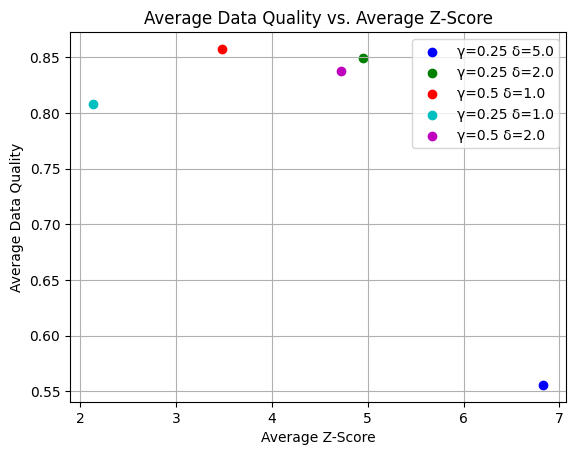

In [19]:
"""
Trade-off between strength (z-score) and data quality (using synthcity)
"""
import matplotlib.pyplot as plt

def plot_data_quality_vs_z_score(gamma_delta_pairs, sample_size, num_tokens):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each point

    for i, (gamma, delta) in enumerate(gamma_delta_pairs):
        real_file_name, no_water_mark_file_name , with_water_mark_file_name = get_filenames_from_model("diabetes", common_size=1000, gamma=gamma, delta=delta)
    
        average_data_quality_result = average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size)
        avg_qual = average_data_quality_result["avg_final_score"]["With-Watermark"]
        
        avg_z = average_zscore(with_water_mark_file_name, gamma, delta, num_tokens)
        plt.scatter(avg_z, avg_qual, c=colors[i], label=f'γ={gamma} δ={delta}')  # Use different colors for each point
    
    # plt.scatter(average_zscores, average_data_qualities, c=colors[:len(average_zscores)])  # Use different colors for each point
    plt.xlabel('Average Z-Score')
    plt.ylabel('Average Data Quality')
    plt.title('Average Data Quality vs. Average Z-Score')
    
    # for i, txt in enumerate(labels):
    #     plt.annotate(txt, (average_zscores[i]
    #     , average_data_qualities[i]), fontsize=12, ha='right', va='bottom')
    plt.legend()
    plt.grid(True)
    # plt.savefig("avg_zscore_and_data_quality.png")
    plt.show()

gamma_delta_pairs = [(0.25, 5.0), (0.25, 2.0), (0.5, 1.0), (0.25, 1.0), (0.5, 2.0)]
plot_data_quality_vs_z_score(gamma_delta_pairs, 1000, 200)
    

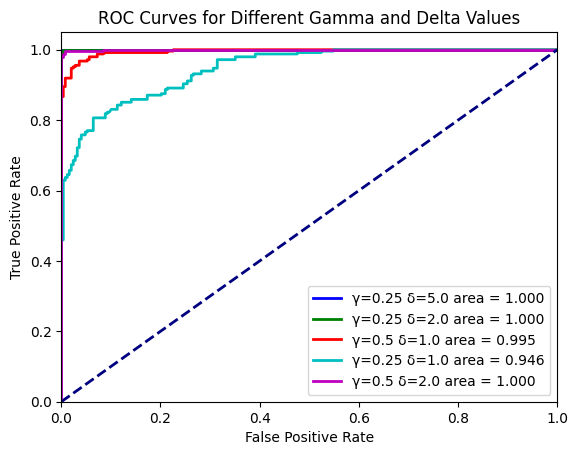

In [18]:
"""
Compute ROC and AOC
"""
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compute_roc_auc(model_names, gamma_delta_pairs, num_samples_per_class, num_tokens_per_sample):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    
    results = []
    
    for gamma, delta in gamma_delta_pairs:
        great_watermark_detector = get_detector(gamma, delta)
        real_scores = []
        gen_scores = []
        for model_name in model_names:
            samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
            real_name, _, syn_name = get_filenames_from_model(model_name, 1000, gamma, delta)
            real_df = pd.read_csv(samples_dir + real_name)
            syn_df = pd.read_csv(samples_dir + syn_name)
            for i in range(int(num_samples_per_class / len(model_names))):
                real_scores.append(great_watermark_detector.detect(real_df, total_tokens_limit=num_tokens_per_sample, random_state=i)['z_score'])
                gen_scores.append(great_watermark_detector.detect(syn_df, total_tokens_limit=num_tokens_per_sample, random_state=i)['z_score'])

        # Compute roc auc 
        y_true = np.concatenate([np.zeros(len(real_scores)), np.ones(len(gen_scores))])
        y_scores = np.concatenate([real_scores, gen_scores])
        
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        results.append((gamma, delta, fpr, tpr, roc_auc))
    
    return results

def plot_roc_curves(results):
    plt.figure()
    lw = 2
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each point

    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(results):
        plt.plot(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} area = {roc_auc:.3f}', c=colors[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Gamma and Delta Values')
    plt.legend(loc="lower right")
    plt.savefig("roc_curves.png")
    plt.show()

gamma_delta_pairs = [(0.25, 5.0), (0.25, 2.0), (0.5, 1.0), (0.25, 1.0), (0.5, 2.0)]

results = compute_roc_auc(
    ["california", "abalone", "adult", "diabetes"],
    gamma_delta_pairs=gamma_delta_pairs,
    num_samples_per_class=250,
    num_tokens_per_sample=200
)

# Plot all ROC curves
plot_roc_curves(results)

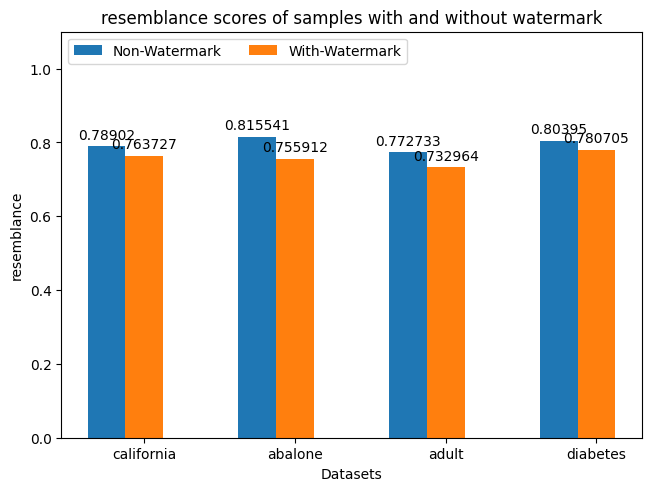

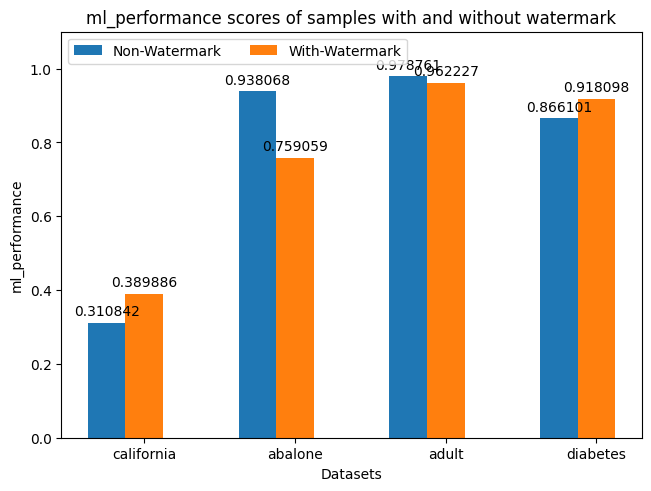

In [9]:
def plot_single_metric_between_model(model_names, metric_name, gamma, delta, sample_size=1000):

    non_watermark_scores = []
    with_watermark_scores = []
    for model_name in model_names:
        real_file_name, no_water_mark_file_name , with_water_mark_file_name = get_filenames_from_model(model_name, common_size=1000, gamma=0.25, delta=2.0)
        average_data_quality_result = average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size)
        non_watermark_scores.append(average_data_quality_result[metric_name]["No-Watermark"])
        with_watermark_scores.append(average_data_quality_result[metric_name]["With-Watermark"])
    
    scores = {
        "Non-Watermark": non_watermark_scores,
        "With-Watermark": with_watermark_scores
    }
            

    x = np.arange(len(model_names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0    
    
    fig, ax = plt.subplots(layout='constrained')
    
    for attribute, measurement in scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric_name)
    ax.set_xlabel("Datasets")
    ax.set_title(f"{metric_name} scores of samples with and without watermark")
    ax.set_xticks(x + width, model_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.1)
    # plt.savefig(f"{metric_name}_between_datasets.png")
    plt.show()

plot_single_metric_between_model(model_names = ["california", "abalone", "adult", "diabetes"],
                                 metric_name="resemblance",
                                 gamma=0.25,
                                 delta=2.0,
                                 sample_size=1000)

plot_single_metric_between_model(model_names = ["california", "abalone", "adult", "diabetes"],
                                 metric_name="ml_performance",
                                 gamma=0.25,
                                 delta=2.0,
                                 sample_size=1000)